# Minimum Temperature

By Alberto Valdés 

**Mail 1:** anvaldes@uc.cl 

**Mail 2:** alberto.valdes.gonzalez.96@gmail.com

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)

In [3]:
import time
import math
import scipy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from matplotlib import image as mpimg

In [4]:
def display_img(name, a, b):
    plt.figure(figsize = (a, b))
    image = mpimg.imread(name)
    plt.imshow(image)
    plt.axis('off')
    plt.show()

In [5]:
def transform_date(date):

    try:

        new_date = date.year + (date.month - 1)/12 + date.day/365

        return new_date
    
    except:

        return float('nan')

In [6]:
def transform_value(value):

    try:

        return float(value)
    
    except:

        return float('nan')

In [7]:
start = time.time()

# 1. Read DataFrame

In [8]:
df = pd.read_csv('Temp.csv', skiprows = [3652])

df = df.rename(columns = {'Date': 'Time', 'Daily minimum temperatures in Melbourne, Australia, 1981-1990': 'X_t'})

df['Time'] = pd.to_datetime(df['Time'])

df['X_t'] = df['X_t'].map(lambda x: transform_value(x))

df = df.dropna()

df['key_Date'] = df['Time'].dt.year.apply(str) + '-' + df['Time'].dt.month.apply(str)

df = df[['key_Date', 'X_t']].groupby(by = ['key_Date'], as_index = False).mean().copy()

df['key_Date'] = pd.to_datetime(df['key_Date'])
df = df.rename(columns = {'key_Date': 'Time'})

df['Time'] = df['Time'].map(lambda x: transform_date(x))

df = df.sort_values(by = ['Time'], ascending = True)
df = df.reset_index()
df = df.drop(columns = ['index'])

# 2. Split

In [9]:
train = df[df['Time'] <= 1986.005479]
val = df[(df['Time'] > 1986.005479) & (df['Time'] <= 1988.504110)]
test = df[df['Time'] > 1988.504110]

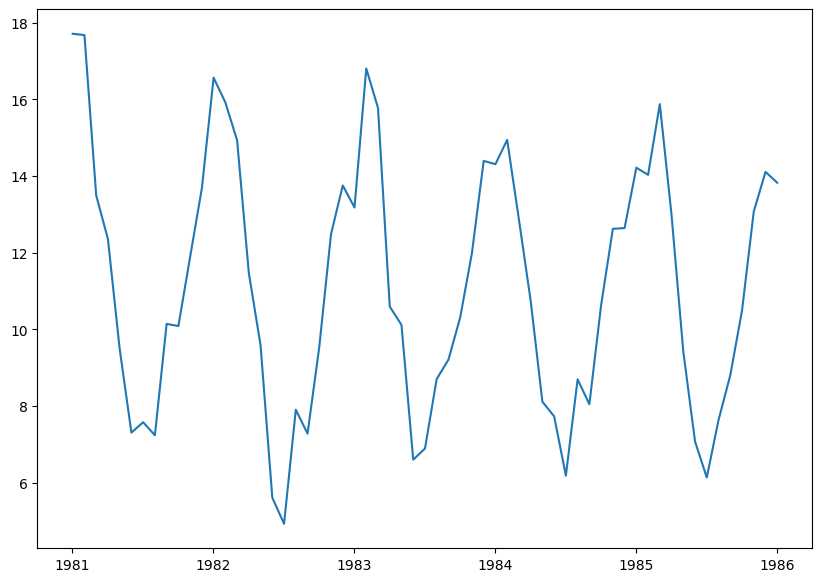

In [10]:
plt.figure(figsize = (10, 7))
plt.plot(train['Time'], train['X_t'])
plt.show()

# 3. BoxCox

We dont apply anything.

# 4. Exogen Regression

We dont have exogen variables.

# 5. Endogen Regression

We dont use any.

# 6. ACF and PACF

In [11]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

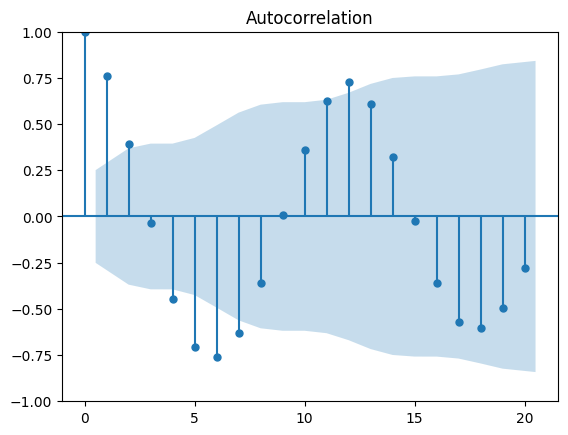

In [12]:
plot_acf(train['X_t'], lags = 20)
plt.show()

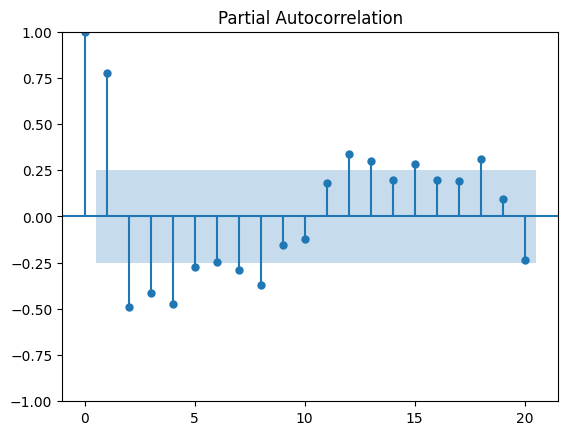

In [13]:
plot_pacf(train['X_t'], lags = 20)
plt.show()

# 7. New period

In [14]:
from scipy import signal

In [15]:
f, Pxx = signal.periodogram(train['X_t'])

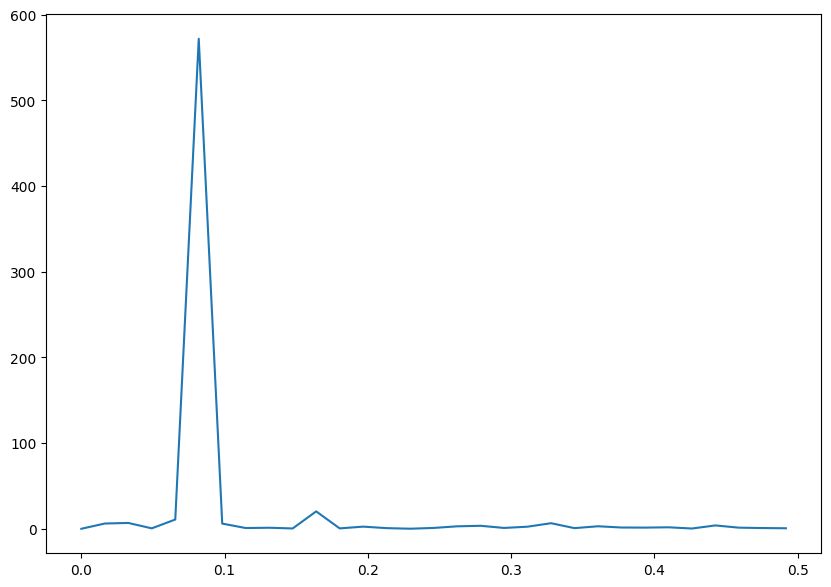

In [16]:
plt.figure(figsize = (10, 7))
plt.plot(f, Pxx)
plt.show()

In [17]:
T = 1/f[Pxx.argmax()]

In [18]:
T

12.2

# 8. Stationary

In [19]:
from statsmodels.tsa.stattools import adfuller

In [20]:
result = adfuller(train['X_t'].values)

In [21]:
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -6.392729
p-value: 0.000000
Critical Values:
	1%: -3.560
	5%: -2.918
	10%: -2.597


**Comments:** Is stationary.

# 9. Hyperparameter tuning

In [22]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

### Very Important: The index are used to predict

(p, d, q) = (AR, Differences, MA)

In [23]:
all_params = []

for p in [0, 1, 2]:
    for d in [0, 1]:
        for q in [0, 1, 2]:
            for P in [0, 1, 2]:
                for D in [0, 1, 2]:
                    for Q in [0, 1]:
                        all_params.append({'p': p, 'd': d, 'q': q, 'P': P, 'D': D, 'Q': Q})

In [24]:
len(all_params)

324

In [25]:
column_p = []
column_d = []
column_q = []

column_P = []
column_D = []
column_Q = []

column_train = []
column_val = []

start_iter = time.time()

c = 0

for param in all_params:

    c = c + 1

    p = param['p']
    d = param['d']
    q = param['q']
    P = param['P']
    D = param['D']
    Q = param['Q']

    model = SARIMAX(train['X_t'], order = (p, d, q), seasonal_order = (P, D, Q, 12), mle_regression = False, trend = None)
    model_fit = model.fit(disp = False)
    
    error_train = ((model_fit.predict(train.index.min(), train.index.max()) - train['X_t'])**2).mean()
    error_val = ((model_fit.predict(val.index.min(), val.index.max()) - val['X_t'])**2).mean()
    
    column_p.append(p)
    column_d.append(d)
    column_q.append(q)

    column_P.append(P)
    column_D.append(D)
    column_Q.append(Q)

    column_train.append(error_train)
    column_val.append(error_val)

    if (c % 10) == 0:

        end_iter = time.time()

        delta_iter = (end_iter - start_iter)

        hours_iter = int(delta_iter/3600)
        mins_iter = int((delta_iter - hours_iter*3600)/60)
        segs_iter = int(delta_iter - hours_iter*3600 - mins_iter*60)
        print(f'c = {c}')
        print(f'Execute this iteration take us {hours_iter} hours, {mins_iter} minutes and {segs_iter} seconds.')
        print('-'*70)

        start_iter = time.time()

c = 10
Execute this iteration take us 0 hours, 0 minutes and 0 seconds.
----------------------------------------------------------------------
c = 20
Execute this iteration take us 0 hours, 0 minutes and 2 seconds.
----------------------------------------------------------------------
c = 30
Execute this iteration take us 0 hours, 0 minutes and 1 seconds.
----------------------------------------------------------------------
c = 40
Execute this iteration take us 0 hours, 0 minutes and 2 seconds.
----------------------------------------------------------------------
c = 50
Execute this iteration take us 0 hours, 0 minutes and 2 seconds.
----------------------------------------------------------------------
c = 60
Execute this iteration take us 0 hours, 0 minutes and 2 seconds.
----------------------------------------------------------------------
c = 70
Execute this iteration take us 0 hours, 0 minutes and 1 seconds.
----------------------------------------------------------------------

In [26]:
ht = pd.DataFrame()

ht['p'] = column_p
ht['d'] = column_d
ht['q'] = column_q

ht['P'] = column_P
ht['D'] = column_D
ht['Q'] = column_Q

ht['error_train'] = column_train
ht['error_val'] = column_val

In [27]:
ht[ht['error_val'] == ht['error_val'].min()]

,p,d,q,P,D,Q,error_train,error_val
300,2,1,1,2,0,0,7.899142,0.80819


# 10. Definitive model

In [28]:
model = SARIMAX(train['X_t'], order = (2, 1, 1), seasonal_order = (2, 0, 0, 12))
model_fit = model.fit(disp = False)

In [29]:
train['predict'] = model_fit.predict(train.index.min(), train.index.max())
val['predict'] = model_fit.predict(val.index.min(), val.index.max())
test['predict'] = model_fit.predict(test.index.min(), test.index.max())

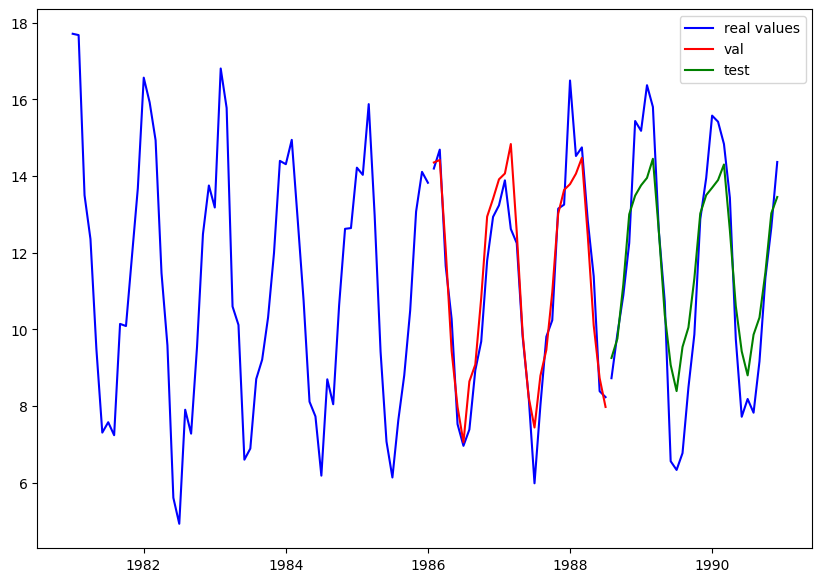

In [30]:
plt.figure(figsize = (10, 7))
plt.plot(train['Time'], train['X_t'], color = 'blue', label = 'real values')

plt.plot(val['Time'], val['X_t'], color = 'blue')
plt.plot(test['Time'], test['X_t'], color = 'blue')

plt.plot(val['Time'], val['predict'], color = 'red', label = 'val')
plt.plot(test['Time'], test['predict'], color = 'green', label ='test')
plt.legend()
plt.show()

# 11. Performance Metrics

In [31]:
print('MSE val:', round(((val['predict'] - val['X_t'])**2).mean(), 2))
print('MAE val:', round((abs(val['predict'] - val['X_t'])).mean(), 2))
print('MAPE val:', round((abs(val['predict'] - val['X_t'])/val['X_t']).mean()*100, 2))

MSE val: 0.81
MAE val: 0.65
MAPE val: 6.16


In [32]:
print('MSE test:', round(((test['predict'] - test['X_t'])**2).mean(), 2))
print('MAE test:', round((abs(test['predict'] - test['X_t'])).mean(), 2))
print('MAPE test:', round((abs(test['predict'] - test['X_t'])/test['X_t']).mean()*100, 2))

MSE test: 1.89
MAE test: 1.13
MAPE test: 11.49


# 12. Errors

In [33]:
val['error'] = val['X_t'] - val['predict']
test['error'] = test['X_t'] - test['predict']

### i. Normality

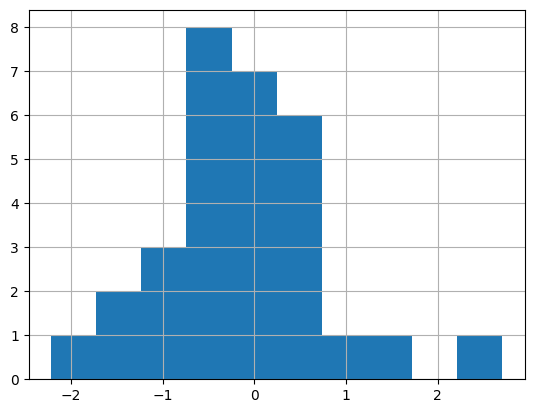

In [34]:
val['error'].hist(bins = 10)
plt.show()

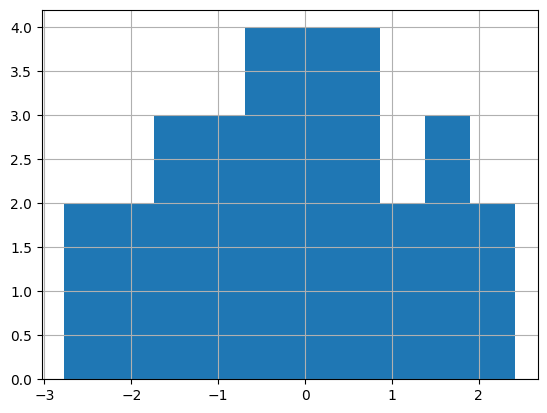

In [35]:
test['error'].hist(bins = 10)
plt.show()

**Comments:** We don't see the normality because with only the histogram is clearly that the errors isn't normals.

### ii. PACF and ACF

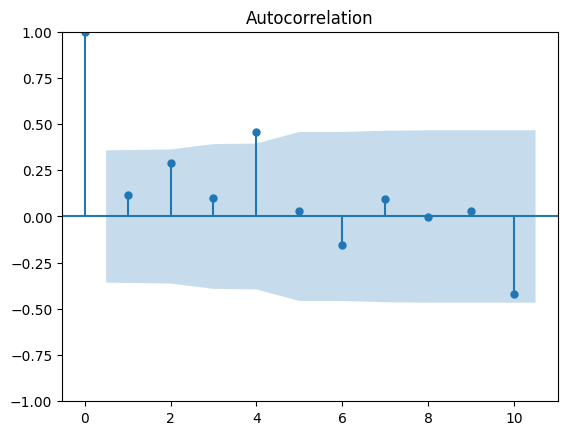

In [36]:
plot_acf(val['error'], lags = 10)
plt.show()

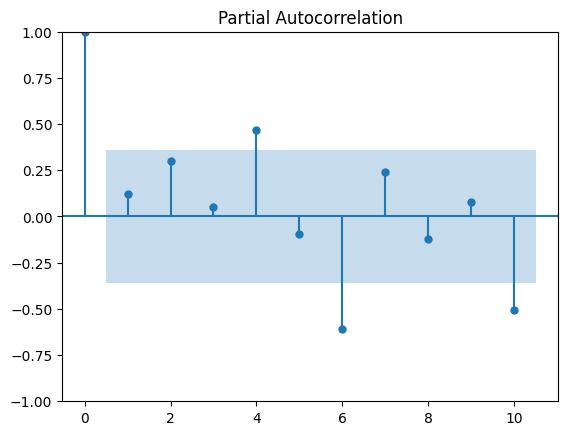

In [37]:
plot_pacf(val['error'], lags = 10)
plt.show()

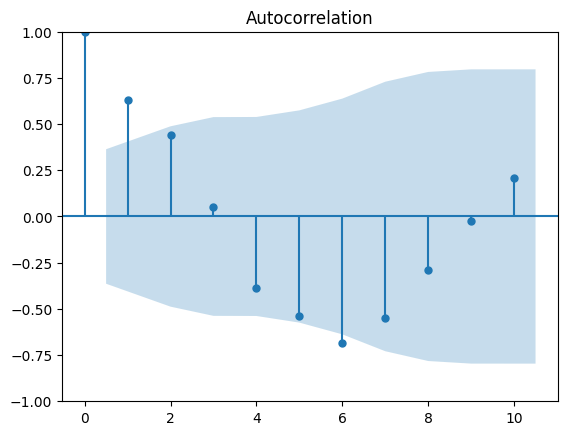

In [38]:
plot_acf(test['error'], lags = 10)
plt.show()

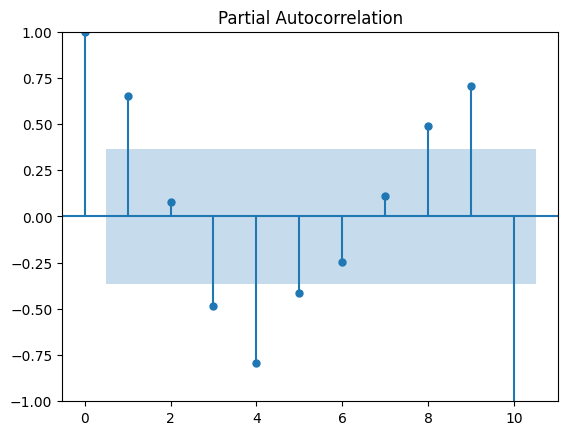

In [39]:
plot_pacf(test['error'], lags = 10)
plt.show()

### iii. Stationary

In [40]:
result_val = adfuller(val['error'].values)

In [41]:
print('ADF Statistic: %f' % result_val[0])
print('p-value: %f' % result_val[1])
print('Critical Values:')
for key, value in result_val[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -1.051457
p-value: 0.734037
Critical Values:
	1%: -3.809
	5%: -3.022
	10%: -2.651


**Comment:** Is not stationary.

In [42]:
result_test = adfuller(test['error'].values)

In [43]:
print('ADF Statistic: %f' % result_test[0])
print('p-value: %f' % result_test[1])
print('Critical Values:')
for key, value in result_test[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -3.973122
p-value: 0.001558
Critical Values:
	1%: -3.753
	5%: -2.998
	10%: -2.639


**Comment:** Is stationary.

### Time of execution

In [44]:
end = time.time()

In [45]:
delta = (end - start)

hours = int(delta/3600)
mins = int((delta - hours*3600)/60)
segs = int(delta - hours*3600 - mins*60)
print(f'Execute this notebook take us {hours} hours, {mins} minutes and {segs} seconds.')

Execute this notebook take us 0 hours, 1 minutes and 57 seconds.
